# Time Series Change-Point Detection with MAUQ API

This notebook shows how to identify structural breaks time series via the MAUQ 'quantify-uncertainty'. This notebook will cover:

1. Loading and preprocessing time series data  
2. Applying crepes algorithms to generate multiple intervals of uncertainity 
3. Calling MAUQ’s  API to generate intervals of uncertainity, based on the size of the calibration set
4. Compare manual vs. MAUQ-detected change points  
5. Visualizing results to assess effectiveness


In [ ]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [2]:
file_name = 'car_price_dataset.csv'

In [3]:
dataset = pd.read_csv(file_name)

In [4]:
dataset.shape

(10000, 10)

In [5]:
dataset.columns

Index(['Brand', 'Model', 'Year', 'Engine_Size', 'Fuel_Type', 'Transmission',
       'Mileage', 'Doors', 'Owner_Count', 'Price'],
      dtype='object')

In [6]:
dataset.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [7]:
# time_col = dataset.columns[0]
# target_col = dataset.columns[-1]
# dataset[time_col] = dataset[time_col].astype(str)
# dataset.set_index(time_col, inplace=True)

from sklearn.preprocessing import OneHotEncoder
#Extract categorical columns from the dataframe
#Here we extract the columns with object datatype as they are the categorical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(dataset[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([dataset, one_hot_df], axis=1)

# Drop the original categorical columns
dataset = df_encoded.drop(categorical_columns, axis=1)


dataset.insert(len(dataset.columns)-1, 'Price', dataset.pop('Price'))
target_col = dataset.columns[-1]

In [8]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

In [9]:
train_points = int(train_size*len(train_df)) #further split train dataset to train and calibration
cal_df = train_df.iloc[train_points:]
train_df = train_df.iloc[:train_points]

In [10]:
df_dict = {'train': train_df, 'calibration': cal_df, 'test': test_df}
for key, value in df_dict.items():
    print(f'{key} dataframe shape: {value.shape}')

train dataframe shape: (6400, 53)
calibration dataframe shape: (1600, 53)
test dataframe shape: (2000, 53)


<Axes: >

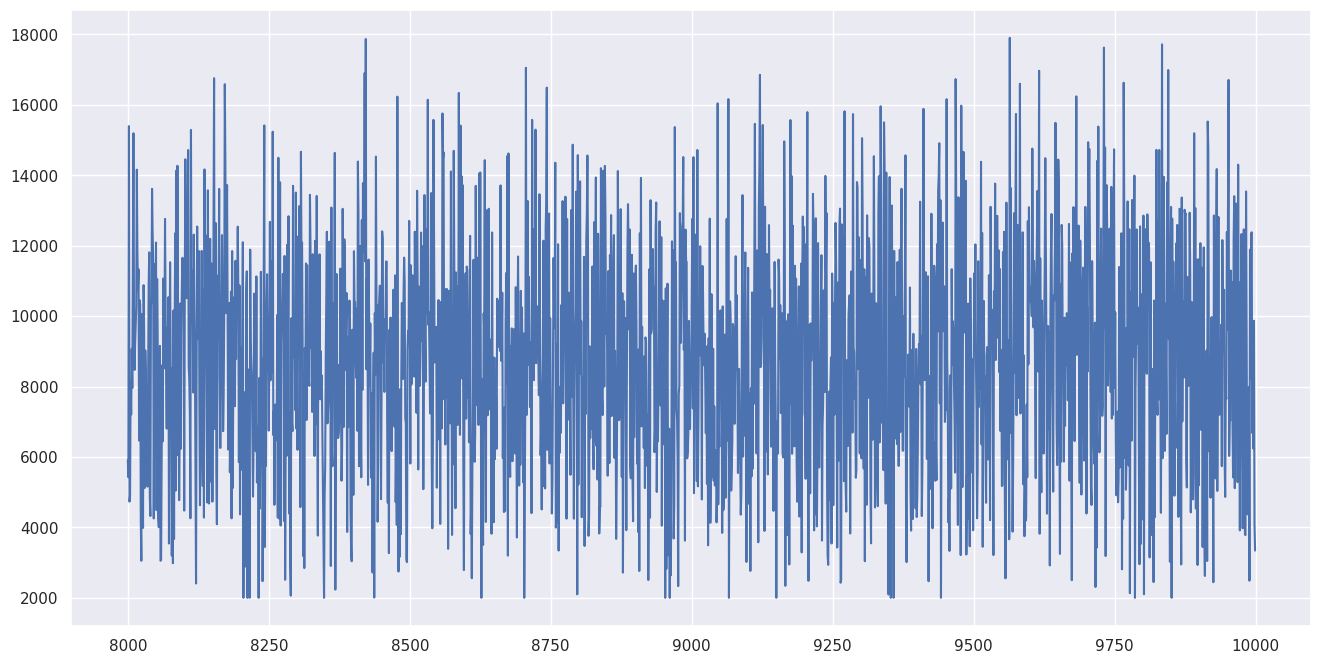

In [11]:
figsize = (16, 8)
test_df[target_col].plot(figsize=figsize)

### **Base model fitting (prior to fit mauq)**

In [12]:
from sklearn.linear_model import Ridge
train_X = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]
cal_X = cal_df.iloc[:, :-1]
cal_y = cal_df.iloc[:, -1]
test_X = test_df.iloc[:, :-1]
test_y = test_df.iloc[:, -1]

regr = Ridge(alpha=0.01) #TODO: change base regressor to Multivariate Time series compatible methods
regr.fit(train_X, train_y)

Ridge(alpha=0.01)

In [13]:
y_pred_cal = regr.predict(cal_X)
y_pred_test = regr.predict(test_X)

In [14]:
#data input calibration set
input_data_cal = pd.concat([cal_X, pd.DataFrame(cal_y)], axis=1)
input_data_cal['y_pred'] = y_pred_cal
input_data_cal

,Year,Engine_Size,Mileage,Doors,Owner_Count,Brand_Audi,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,...,Model_X5,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Transmission_Semi-Automatic,Price,y_pred
6400,2003,2.5,150292,5,3,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4494,4534.296105
6401,2001,4.9,49981,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9300,9297.806817
6402,2004,3.9,250312,4,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6193,6223.336630
6403,2000,1.9,202579,5,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2948,2975.809192
6404,2007,3.8,247278,4,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7054,7062.016227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2006,1.8,288220,3,3,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5435,5467.252628
7996,2004,3.1,196259,3,4,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4474,4510.356832
7997,2006,3.1,76820,4,3,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7463,7467.401418
7998,2005,1.1,297669,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2000,790.002215


In [15]:
#data input test set (optional)
input_data_test = pd.concat([test_X, pd.DataFrame(test_y)], axis=1)
input_data_test['y_pred'] = y_pred_test
input_data_test

,Year,Engine_Size,Mileage,Doors,Owner_Count,Brand_Audi,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,...,Model_X5,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Transmission_Semi-Automatic,Price,y_pred
8000,2000,4.5,134919,5,5,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5901,5927.676823
8001,2001,3.3,188704,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5425,5442.205874
8002,2022,2.5,65076,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,15398,15368.942521
8003,2000,3.5,243409,2,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4731,4753.967565
8004,2006,1.6,129395,2,3,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4912,4938.372713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2004,3.7,5794,2,4,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8884,8898.182666
9996,2002,1.4,168000,2,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6240,6254.845175
9997,2010,3.0,86664,5,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9866,9872.149358
9998,2002,1.4,225772,4,1,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4084,4115.045513


In [16]:
#data input train set (optional)
input_data_train = pd.concat([train_X, pd.DataFrame(train_y)], axis=1)
input_data_train

,Year,Engine_Size,Mileage,Doors,Owner_Count,Brand_Audi,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,...,Model_Tucson,Model_X5,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Transmission_Semi-Automatic,Price
0,2020,4.2,289944,3,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8501
1,2012,2.0,5356,2,3,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,12092
2,2020,4.2,231440,4,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,11171
3,2023,2.0,160971,2,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11780
4,2003,2.6,286618,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,2003,2.6,96060,5,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7178
6396,2018,3.3,89393,3,5,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,14512
6397,2023,2.1,53707,2,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,15525
6398,2012,2.4,222315,2,5,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6653


### **Crepes**

### Conformal Prediction with `crepes`

`crepes` is a Python package that implements conformal classifiers, regressors, and predictive systems, on top of any standard classifier and regressor, transforming the original predictions into well-calibrated p-values and cumulative distribution functions, or prediction sets and intervals with coverage guarantees.


In [ ]:
from crepes import ConformalClassifier, ConformalRegressor, ConformalPredictiveSystem, __version__

from crepes.extras import hinge, margin, binning, DifficultyEstimator

print(f"crepes v. {__version__}")

: 

In [18]:
cr_std = ConformalRegressor()
display(cr_std)

ConformalRegressor(fitted=False)

In [19]:
residuals_cal = cal_y - y_pred_cal
display(residuals_cal)

6400     -40.296105
6401       2.193183
6402     -30.336630
6403     -27.809192
6404      -8.016227
           ...     
7995     -32.252628
7996     -36.356832
7997      -4.401418
7998    1209.997785
7999     -16.985827
Name: Price, Length: 1600, dtype: float64

In [20]:
cr_std.fit(residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [21]:
intervals = cr_std.predict(test_y, confidence=0.90)

display(intervals)

array([[ 5873.033588,  5928.966412],
       [ 5397.033588,  5452.966412],
       [15370.033588, 15425.966412],
       ...,
       [ 9838.033588,  9893.966412],
       [ 4056.033588,  4111.966412],
       [ 3314.033588,  3369.966412]])

In [22]:
intervals_std = cr_std.predict(test_y, y_min=0, y_max=1)

In [23]:
intervals_std

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [24]:
de_knn = DifficultyEstimator()
de_knn.fit(X=train_X, scaler=True)

display(de_knn)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

Create a vector of difficulty estimates (standard deviations) for each point in the calibration set.

In [25]:
sigmas_cal_knn_dist = de_knn.apply(cal_X)

In [26]:
cr_norm_knn_dist = ConformalRegressor()

cr_norm_knn_dist.fit(residuals_cal, sigmas=sigmas_cal_knn_dist)

display(cr_norm_knn_dist)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [27]:
sigmas_test_knn_dist = de_knn.apply(test_X)

intervals_norm_knn_dist = cr_norm_knn_dist.predict(y_pred_test, 
                                                   sigmas=sigmas_test_knn_dist,
                                                   )
intervals_norm_knn_dist = cr_norm_knn_dist.predict(y_pred_test, 
                                                   sigmas=sigmas_test_knn_dist,
                                                   y_min=0, y_max=1)

display(intervals_norm_knn_dist)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

Use standard deviation of targets by suppplying the target values in de_knn_std.fit

In [28]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=train_X, y=train_y, scaler=True)

display(de_knn_std)

sigmas_cal_knn_std = de_knn_std.apply(cal_X)

cr_norm_knn_std = ConformalRegressor()

cr_norm_knn_std.fit(residuals_cal, sigmas=sigmas_cal_knn_std)

display(cr_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [29]:
sigmas_test_knn_std = de_knn_std.apply(test_X)

intervals_norm_knn_std = cr_norm_knn_std.predict(y_pred_test, 
                                                 sigmas=sigmas_test_knn_std,
                                                 y_min=0, y_max=1)

intervals_norm_knn_std = cr_norm_knn_std.predict(y_pred_test, 
                                                 sigmas=sigmas_test_knn_std,
                                                 )

display(intervals_norm_knn_std)

array([[ 5905.41976458,  5949.93388081],
       [ 5395.746748  ,  5488.66499917],
       [15334.38974442, 15403.49529765],
       ...,
       [ 9835.08967504,  9909.20904056],
       [ 4043.97817579,  4186.11285086],
       [ 3337.61868484,  3413.5500092 ]])

In [30]:
lower_interval=intervals_norm_knn_std[:,0]
upper_interval=intervals_norm_knn_std[:,1]


In [31]:
uncertainty_df = pd.DataFrame(data={'y': input_data_test['Price'], 'y_pred': y_pred_test, 'lower_interval': lower_interval, 'upper_interval': upper_interval}).set_index(input_data_test.index)
uncertainty_df

,y,y_pred,lower_interval,upper_interval
8000,5901,5927.676823,5905.419765,5949.933881
8001,5425,5442.205874,5395.746748,5488.664999
8002,15398,15368.942521,15334.389744,15403.495298
8003,4731,4753.967565,4708.319325,4799.615806
8004,4912,4938.372713,4903.275207,4973.470218
...,...,...,...,...
9995,8884,8898.182666,8870.060383,8926.304950
9996,6240,6254.845175,6198.920636,6310.769714
9997,9866,9872.149358,9835.089675,9909.209041
9998,4084,4115.045513,4043.978176,4186.112851


<Axes: >

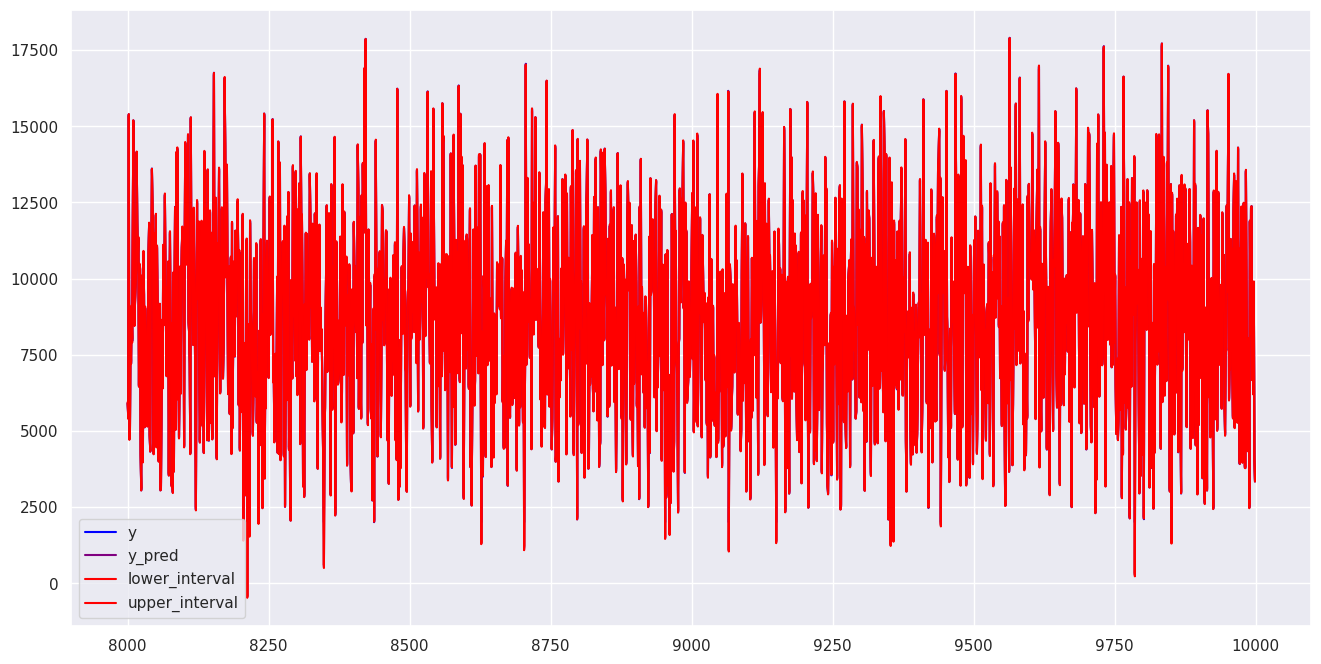

In [32]:
uncertainty_colors = ['blue', 'purple', 'red', 'red']
uncertainty_df.plot(figsize=figsize, color=uncertainty_colors)

In [33]:
de_var = DifficultyEstimator()

de_var.fit(X=train_X, y=train_y, scaler=True)

display(de_var)

sigmas_cal_var = de_var.apply(cal_X)

cps_norm = ConformalPredictiveSystem().fit(residuals_cal,
                                           sigmas=sigmas_cal_var)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

In [34]:
sigmas_test_var = de_var.apply(test_X)

In [35]:

cpds = cps_norm.predict(y_pred_test,
                        sigmas=sigmas_test_var,
                        lower_percentiles=2.5,
                        higher_percentiles=97.5,
                        return_cpds=True
                        )


In [36]:
display(cpds)

(array([[ 5903.11456153,  5946.73542317],
        [ 5390.93489382,  5481.98857569],
        [15330.81105195, 15398.52987986],
        ...,
        [ 9831.25133785,  9903.88336702],
        [ 4036.61760538,  4175.90009643],
        [ 3333.68651375,  3408.09414159]]),
 array([[ 5824.34252923,  5873.258869  ,  5878.29331756, ...,
          7047.80118027,  7330.22178115,  7795.47450507],
        [ 5226.50706506,  5328.61446669,  5339.12331637, ...,
          7780.34049686,  8369.86199131,  9341.02514388],
        [15208.52209438, 15284.46184132, 15292.27752727, ...,
         17107.86985401, 17546.31126362, 18268.58881512],
        ...,
        [ 9700.08995471,  9781.5393549 ,  9789.92209199, ...,
         11737.2410121 , 12207.49264278, 12982.17356697],
        [ 3785.09655627,  3941.28764006,  3957.36275894, ...,
          7691.63031535,  8593.40628519, 10078.96974984],
        [ 3199.31869426,  3282.75924696,  3291.34691261, ...,
          5286.27095863,  5768.01859433,  6561.63775331]])

In [37]:
cpds[0][0]

array([5903.11456153, 5946.73542317])

In [38]:
cpds[1][0]

array([5824.34252923, 5873.258869  , 5878.29331756, ..., 7047.80118027,
       7330.22178115, 7795.47450507])

In [39]:
import numpy as np
np.percentile(cpds[1][0], 97.5)

5946.615212010424

In [40]:
np.argwhere(cpds[1][0]==cpds[0][0][0])

array([[39]])

In [41]:
cpds[1]

array([[ 5824.34252923,  5873.258869  ,  5878.29331756, ...,
         7047.80118027,  7330.22178115,  7795.47450507],
       [ 5226.50706506,  5328.61446669,  5339.12331637, ...,
         7780.34049686,  8369.86199131,  9341.02514388],
       [15208.52209438, 15284.46184132, 15292.27752727, ...,
        17107.86985401, 17546.31126362, 18268.58881512],
       ...,
       [ 9700.08995471,  9781.5393549 ,  9789.92209199, ...,
        11737.2410121 , 12207.49264278, 12982.17356697],
       [ 3785.09655627,  3941.28764006,  3957.36275894, ...,
         7691.63031535,  8593.40628519, 10078.96974984],
       [ 3199.31869426,  3282.75924696,  3291.34691261, ...,
         5286.27095863,  5768.01859433,  6561.63775331]])

In [42]:
import numpy as np

def compute_percentiles(data, num_bins=None):
    """
    Compute percentile values for a given distribution.
    
    Parameters:
        data (array-like): The input distribution.
        num_bins (int, optional): Number of bins to split the distribution into.
    
    Returns:
        np.ndarray: Array of computed percentile values.
    """
    if num_bins:
        percentiles = np.linspace(0, 100, num_bins + 1)
    else:
        percentiles = np.linspace(0, 100, 11)  # Default to deciles
    
    return [np.percentile(x, percentiles) for x in data]

percentiles = compute_percentiles(cpds[1], num_bins=10)  # Get deciles
print(percentiles)
percentile_cols = [str(x) + ' percentile' for x in np.linspace(0, 100, 11)]
percentile_cols

[array([5824.34252923, 5912.14924304, 5916.12437088, 5919.73118515,
       5922.33053439, 5924.37185944, 5926.5912967 , 5929.61387485,
       5932.50488798, 5937.43212488, 7795.47450507]), array([5226.50706506, 5409.79378349, 5418.09141934, 5425.62024171,
       5431.04609324, 5435.30713152, 5439.93995919, 5446.24925385,
       5452.28392119, 5462.5689785 , 9341.02514388]), array([15208.52209438, 15344.83686483, 15351.00801752, 15356.60738502,
       15360.64272218, 15363.81175952, 15367.25730563, 15371.94968084,
       15376.43780906, 15384.08705521, 18268.58881512]), array([4542.033506  , 4722.12118728, 4730.27399842, 4737.67141475,
       4743.00256492, 4747.18923219, 4751.74119973, 4757.94037365,
       4763.86971353, 4773.97525821, 8584.73789144]), array([4775.42323644, 4913.88702752, 4920.15546927, 4925.84311154,
       4929.94206633, 4933.16106398, 4936.66092959, 4941.42728071,
       4945.98616488, 4953.75600242, 7883.73231938]), array([8068.41951297, 8153.4586203 , 8157.308454

['0.0 percentile',
 '10.0 percentile',
 '20.0 percentile',
 '30.0 percentile',
 '40.0 percentile',
 '50.0 percentile',
 '60.0 percentile',
 '70.0 percentile',
 '80.0 percentile',
 '90.0 percentile',
 '100.0 percentile']

In [43]:
percentiles[-1]

array([3199.31869426, 3349.09769993, 3355.87839663, 3362.03083113,
       3366.46475113, 3369.94680418, 3373.73267763, 3378.88853338,
       3383.81996803, 3392.22475409, 6561.63775331])

In [44]:
pd.DataFrame(data=percentiles, columns=percentile_cols)

,0.0 percentile,10.0 percentile,20.0 percentile,30.0 percentile,40.0 percentile,50.0 percentile,60.0 percentile,70.0 percentile,80.0 percentile,90.0 percentile,100.0 percentile
0,5824.342529,5912.149243,5916.124371,5919.731185,5922.330534,5924.371859,5926.591297,5929.613875,5932.504888,5937.432125,7795.474505
1,5226.507065,5409.793783,5418.091419,5425.620242,5431.046093,5435.307132,5439.939959,5446.249254,5452.283921,5462.568978,9341.025144
2,15208.522094,15344.836865,15351.008018,15356.607385,15360.642722,15363.811760,15367.257306,15371.949681,15376.437809,15384.087055,18268.588815
3,4542.033506,4722.121187,4730.273998,4737.671415,4743.002565,4747.189232,4751.741200,4757.940374,4763.869714,4773.975258,8584.737891
4,4775.423236,4913.887028,4920.155469,4925.843112,4929.942066,4933.161064,4936.660930,4941.427281,4945.986165,4953.756002,7883.732319
...,...,...,...,...,...,...,...,...,...,...,...
1995,8767.617509,8878.563227,8883.585889,8888.143178,8891.427513,8894.006772,8896.811080,8900.630174,8904.283033,8910.508705,11258.186204
1996,5995.200674,6215.829563,6225.817730,6234.880447,6241.411742,6246.540908,6252.117612,6259.712339,6266.976488,6279.356985,10947.995731
1997,9700.089955,9846.294765,9852.913653,9858.919271,9863.247384,9866.646344,9870.341875,9875.374696,9880.188451,9888.392673,12982.173567
1998,3785.096556,4065.465567,4078.158249,4089.674896,4097.974682,4104.492684,4111.579402,4121.230569,4130.461645,4146.194435,10078.969750


## API

In [45]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [46]:
api_json = {
    'data': input_data_cal.values.tolist(),
    'train': input_data_train.values.tolist(),
    'test': input_data_test.values.tolist(),
    'problem_type': 'regression',
    'proba_type': 'distribution',
    'confidence_level': 0.9,
    'num_bins': 10,
    'output_type': 'data'
}

In [47]:
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [48]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 109 ms, sys: 30.8 ms, total: 140 ms
Wall time: 5.21 s


In [49]:
uncertainty_json_out = response.json()

In [50]:
len(percentile_cols)

11

In [51]:
def get_quantile_column_header(confidence_level, num_bins):
    error_rate = round((1 - confidence_level)*100, 2)
    lower_quantile, upper_quantile = error_rate/2, 100 - error_rate/2
    quantiles = np.linspace(lower_quantile, upper_quantile, num=num_bins+1)
    quantile_cols = [f'{quantile}% quantile' for quantile in quantiles]
    return quantile_cols

In [52]:
quantile_cols = get_quantile_column_header(api_json['confidence_level'], api_json['num_bins'])
uncertainty_cols = list(input_data_test.columns) + quantile_cols
uncertainty_df = pd.DataFrame(uncertainty_json_out['output'], columns=uncertainty_cols)

In [53]:
uncertainty_df.loc[:, 'Price':]

,Price,y_pred,5.0% quantile,14.0% quantile,23.0% quantile,32.0% quantile,41.0% quantile,50.0% quantile,59.0% quantile,68.0% quantile,77.0% quantile,86.0% quantile,95.0% quantile
0,5901.0,5927.676823,5908.384972,5914.170098,5917.394894,5920.249567,5922.511928,5924.371859,5926.382012,5928.883305,5931.574408,5934.992740,5941.696369
1,5425.0,5442.205874,5401.936288,5414.012092,5420.743495,5426.702306,5431.424731,5435.307132,5439.503100,5444.724271,5450.341647,5457.477035,5471.470112
2,15398.0,15368.942521,15338.993055,15347.974123,15352.980431,15357.412142,15360.924325,15363.811760,15366.932403,15370.815514,15374.993293,15380.300053,15390.707044
3,4731.0,4753.967565,4714.400834,4726.265870,4732.879786,4738.734593,4743.374594,4747.189232,4751.311965,4756.442007,4761.961340,4768.972188,4782.721034
4,4912.0,4938.372713,4907.951089,4917.073745,4922.158978,4926.660556,4930.228108,4933.161064,4936.330905,4940.275234,4944.518876,4949.909298,4960.480356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8884.0,8898.182666,8873.806988,8881.116621,8885.191223,8888.798165,8891.656707,8894.006772,8896.546644,8899.707083,8903.107351,8907.426489,8915.896672
1996,6240.0,6254.845175,6206.371210,6220.907295,6229.010130,6236.182967,6241.867522,6246.540908,6251.591748,6257.876661,6264.638502,6273.227627,6290.071603
1997,9866.0,9872.149358,9840.026969,9849.659640,9855.029171,9859.782416,9863.549417,9866.646344,9869.993399,9874.158242,9878.639131,9884.330913,9895.492961
1998,4084.0,4115.045513,4053.446156,4071.918206,4082.215062,4091.330102,4098.553876,4104.492684,4110.911149,4118.897841,4127.490599,4138.405418,4159.810271


In [54]:
eval_metrics = cps_norm.evaluate(y_pred_test, test_y, sigmas=sigmas_test_var, metrics=["time_fit", "CRPS"])['CRPS']
print(f'The CRPS is {eval_metrics}')

The CRPS is 15.232950427666276


In [55]:
uncertainty_df['Price'].describe()

count     2000.000000
mean      8766.735000
std       3207.174153
min       2000.000000
25%       6409.500000
50%       8778.500000
75%      11113.500000
max      17906.000000
Name: Price, dtype: float64

CRPS measures the difference between the predicted probability distribution and the actual observation. More specifically, it measures the scaled deviation between each predicted CPD and actual observation. The final CRPS is the average of the deviations of all observations. A smaller CRPS means the forecast is more accurate.

In this case, our actual target variable ranges from 2000 to 17906 with a mean of 8766.735 and a median of 8778.5. This score means the predicted conformal predictive distribution is pretty close to the actual values given the scale of the data. 

Reference: https://crepes.readthedocs.io/en/latest/_modules/crepes/base.html#WrapRegressor.evaluate